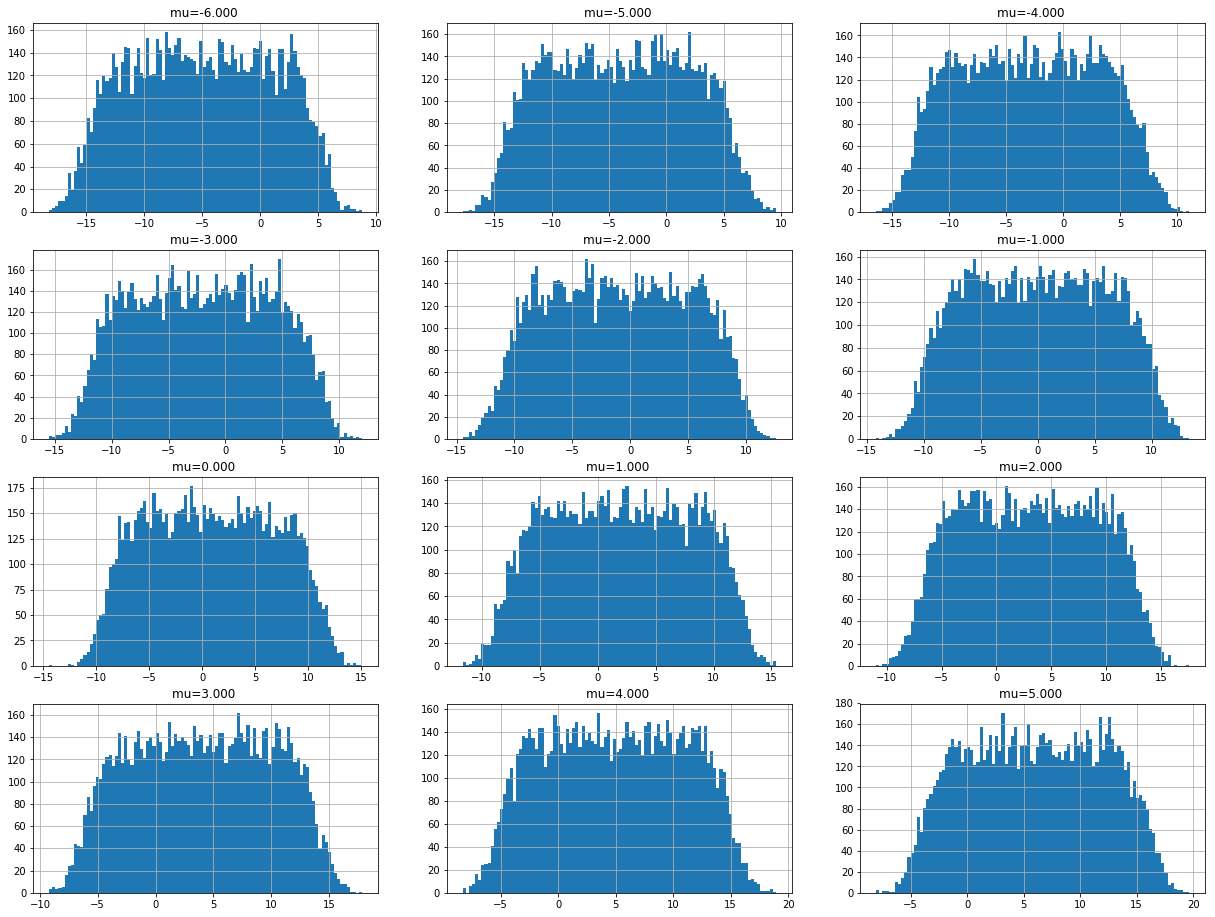

CPU times: user 972 ms, sys: 16 ms, total: 988 ms
Wall time: 973 ms


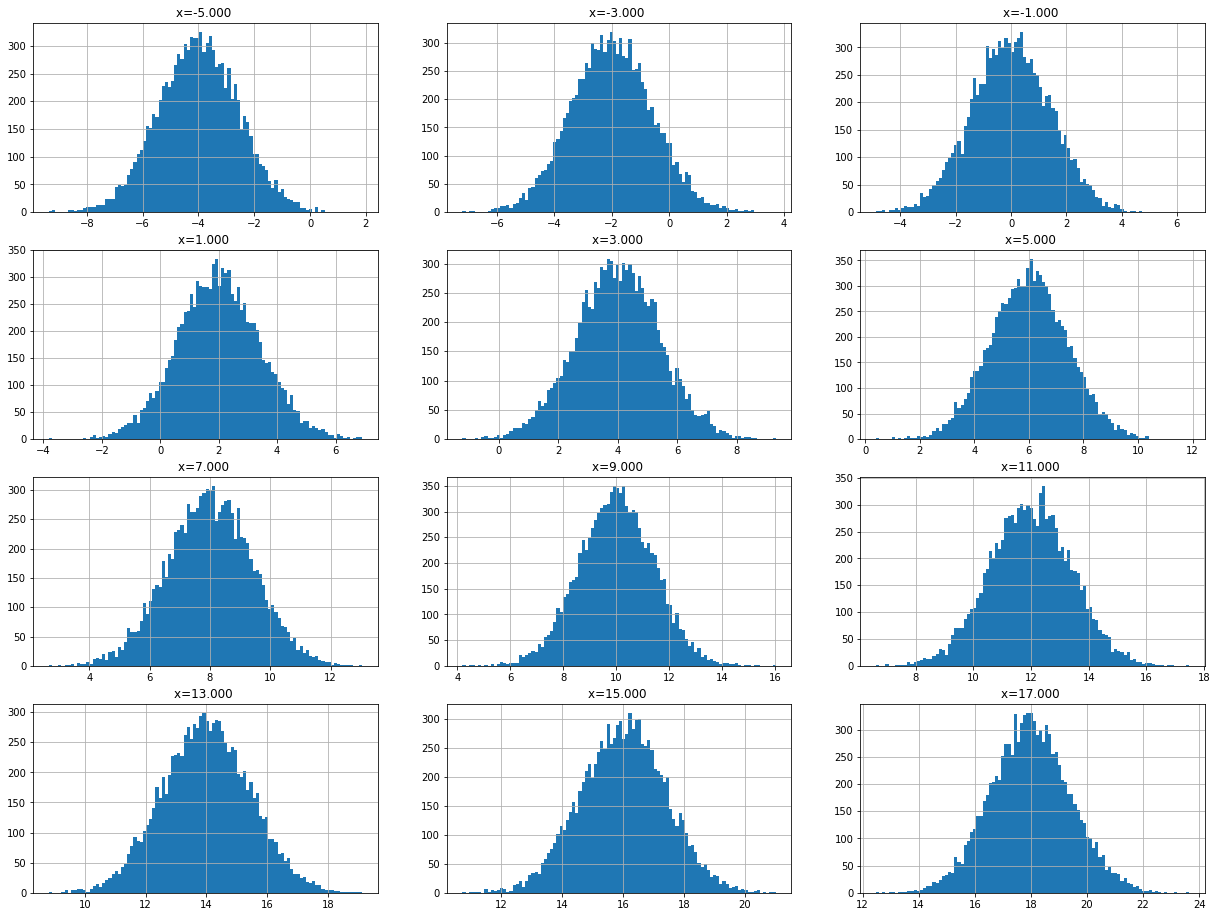

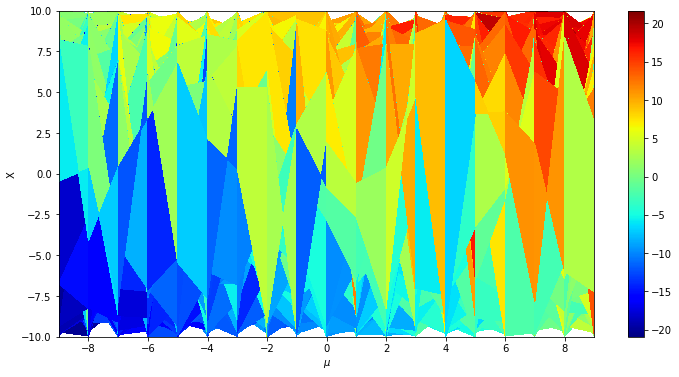

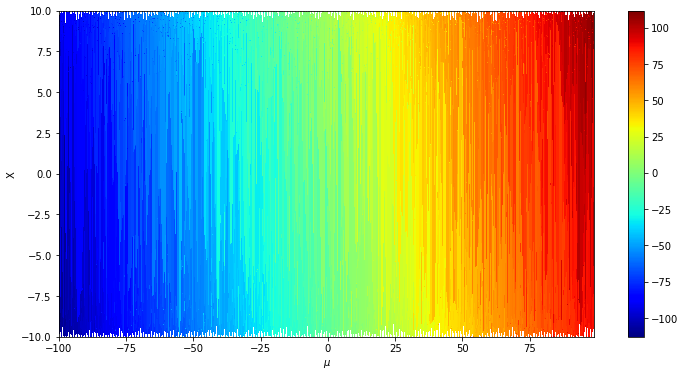

100%|██████████| 100/100 [00:00<00:00, 909.74it/s]


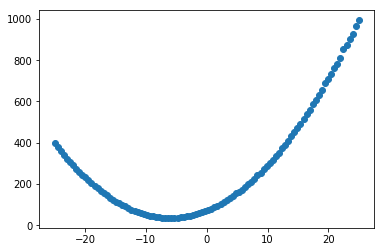

100%|██████████| 100/100 [00:00<00:00, 1038.00it/s]


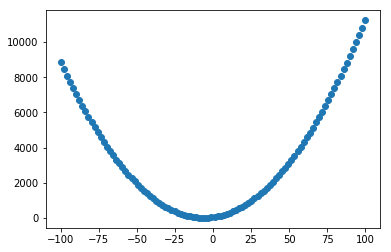

In [1]:
%run -i model.ipynb

## Recovering conditional density with FFJORD

# All needed imports

In [2]:
device = torch.device('cuda:0')

In [3]:
import sys
import torch
import torch.optim as optim
from IPython.display import clear_output

sys.path.append('./ffjord/')
import ffjord.lib.utils as utils
from ffjord.lib.visualize_flow import visualize_transform
import ffjord.lib.layers.odefunc as odefunc
from ffjord.train_misc import standard_normal_logprob
from ffjord.train_misc import count_nfe, count_parameters, count_total_time
from ffjord.train_misc import add_spectral_norm, spectral_norm_power_iteration
from ffjord.train_misc import create_regularization_fns, get_regularization, append_regularization_to_log
from ffjord.train_misc import build_model_tabular
import lib.layers as layers

In [4]:
SOLVERS = ["dopri5", "bdf", "rk4", "midpoint", 'adams', 'explicit_adams', 'fixed_adams']

print(odefunc.NONLINEARITIES)

{'tanh': Tanh(), 'relu': ReLU(), 'softplus': Softplus(beta=1, threshold=20), 'elu': ELU(alpha=1.0), 'swish': Swish(), 'square': Lambda(), 'identity': Lambda()}


In [5]:
def set_cnf_options(model, solver, rademacher, residual, atol=1e-5, rtol=1e-5):

    def _set(module):
        if isinstance(module, layers.CNF):
            # Set training settings
            module.solver = solver
            module.atol = atol
            module.rtol = rtol

            # If using fixed-grid adams, restrict order to not be too high.
            if solver in ['fixed_adams', 'explicit_adams']:
                module.solver_options['max_order'] = 4

        if isinstance(module, layers.ODEfunc):
            module.rademacher = rademacher
            module.residual = residual

    model.apply(_set)
    
# layer_type - ["ignore", "concat", "concat_v2", "squash", "concatsquash", "concatcoord", "hyper", "blend"]
def build_model_tabular(dims=2,
                        layer_type='concatsquash', 
                        nonlinearity='relu', 
                        residual=False, 
                        rademacher=False,
                        train_T=True,
                        solver='dopri5',
                        time_length=0.1,
                        divergence_fn='brute_force', # ["brute_force", "approximate"]
                        hidden_dims=(32, 32), 
                        num_blocks=1, batch_norm=False, 
                        bn_lag=0, regularization_fns=None):


    def build_cnf():
        diffeq = layers.ODEnet(
            hidden_dims=hidden_dims,
            input_shape=(dims,),
            strides=None,
            conv=False,
            layer_type=layer_type,
            nonlinearity=nonlinearity,
        )
        odefunc = layers.ODEfunc(
            diffeq=diffeq,
            divergence_fn=divergence_fn,
            residual=residual,
            rademacher=rademacher,
        )
        cnf = layers.CNF(
            odefunc=odefunc,
            T=time_length,
            train_T=train_T,
            regularization_fns=regularization_fns,
            solver=solver,
        )
        return cnf

    chain = [build_cnf() for _ in range(num_blocks)]
    if batch_norm:
        bn_layers = [layers.MovingBatchNorm1d(dims, bn_lag=bn_lag) for _ in range(num_blocks)]
        bn_chain = [layers.MovingBatchNorm1d(dims, bn_lag=bn_lag)]
        for a, b in zip(chain, bn_layers):
            bn_chain.append(a)
            bn_chain.append(b)
        chain = bn_chain
    model = layers.SequentialFlow(chain)

    set_cnf_options(model, solver, rademacher, residual)

    return model


In [6]:
import ffjord.lib.layers.wrappers.cnf_regularization as reg_lib
import six

REGULARIZATION_FNS = {
    "l1int": reg_lib.l1_regularzation_fn,
    "l2int": reg_lib.l2_regularzation_fn,
    "dl2int": reg_lib.directional_l2_regularization_fn,
    "JFrobint": reg_lib.jacobian_frobenius_regularization_fn,
    "JdiagFrobint": reg_lib.jacobian_diag_frobenius_regularization_fn,
    "JoffdiagFrobint": reg_lib.jacobian_offdiag_frobenius_regularization_fn,
}

def create_regularization_fns(regs={'l1int': 1., 'JFrobint': 1.}):
    regularization_fns = []
    regularization_coeffs = []

    for arg_key, reg_fn in six.iteritems(REGULARIZATION_FNS):
        if arg_key in regs:
            regularization_fns.append(reg_fn)
            regularization_coeffs.append(regs[arg_key])

    regularization_fns = tuple(regularization_fns)
    regularization_coeffs = tuple(regularization_coeffs)
    return regularization_fns, regularization_coeffs


def get_regularization(model, regularization_coeffs):
    if len(regularization_coeffs) == 0:
        return None

    acc_reg_states = tuple([0.] * len(regularization_coeffs))
    for module in model.modules():
        if isinstance(module, layers.CNF):
            acc_reg_states = tuple(acc + reg for acc, reg in zip(acc_reg_states, module.get_regularization_states()))
    return acc_reg_states

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
def get_transforms(model):

    def sample_fn(z, logpz=None):
        if logpz is not None:
            return model(z, logpz, reverse=True)
        else:
            return model(z, reverse=True)

    def density_fn(x, logpx=None):
        if logpx is not None:
            return model(x, logpx, reverse=False)
        else:
            return model(x, reverse=False)

    return sample_fn, density_fn

In [9]:
import math

def standard_normal_logprob(z, data):
    logZ = -0.5 * math.log(2 * math.pi)
    data_ref = torch.stack([torch.zeros(len(data)).to(data.device), 
                            data[:, 1],
                            data[:, 2]], dim=1).float()
    zpow = (z - data_ref).pow(2)
    sigmas = torch.tensor([1., 1., 1.]).float().to(data.device)
    return logZ - zpow / 2 / sigmas


def compute_loss(model, data, batch_size=None):
    # load data
    #x = sample_data(data, batch_size=batch_size)
    #x = torch.from_numpy(x).float().to(device)
    # zero = torch.stack([torch.zeros(data.shape[0]).to(data.device), data[:, 1], data[:, 2]], dim=1).float()
    zero = torch.zeros(data.shape[0], 1).to(data.device)
    # print(zero.shape)
    # transform to z
    #zero[:, 2] = data[:, 2].detach()
    z, delta_logp = model(data, zero)

    # compute log q(z)
    logpz = standard_normal_logprob(z, data).sum(1, keepdim=True)

    logpx = logpz - delta_logp
    loss = -torch.mean(logpx)
    return loss

# Sampling train dataset

In [42]:
n_samples = 10
y_sampler = YModel()
mu_range = (-30, 30)
mus = ((mu_range[0] - mu_range[1]) * (torch.rand(n_samples)) + mu_range[1]).to(device)
xs = y_sampler.x_dist.sample([n_samples]).to(device)
y_sampler.make_condition_sample({'mu': mus, 'X':xs})
data = y_sampler.condition_sample().detach().to(device)
data = torch.stack([data, mus, xs]).detach().t().to(device)

# Optimization is not very stable so should be optimized...

# Defining FFJORD model

In [43]:
regularization_fns = None
#regularization_fns, regularization_coeffs = create_regularization_fns()
model = build_model_tabular(dims=3, 
                            num_blocks=1, 
                            hidden_dims=(32, 32), bn_lag=0.1,
                            regularization_fns=regularization_fns).to(device)

In [44]:
from torch.nn.utils import clip_grad_norm
from tqdm import tqdm

In [45]:
optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-5)

loss_meter = utils.RunningAverageMeter(0.5)
nfef_meter = utils.RunningAverageMeter(0.5)
nfeb_meter = utils.RunningAverageMeter(0.5)

In [46]:
model.train();
for i in tqdm(range(20)):
    optimizer.zero_grad()
    
    loss = compute_loss(model, data)

    loss_meter.update(loss.item())
    # nfe_forward = count_nfe(model)

    loss.backward()
    # clip_grad_norm(model.parameters(), 5)
    optimizer.step()
    if loss.item() < 4:
        break
    nfe_total = count_nfe(model)
    # nfe_backward = nfe_total - nfe_forward
    # nfef_meter.update(nfe_forward)
    # nfeb_meter.update(nfe_backward)
    clear_output()
    print(loss_meter.avg, nfe_total)




100%|██████████| 20/20 [00:30<00:00,  1.47s/it]

12.31768918898888 137.0


In [47]:
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

loss_meter = utils.RunningAverageMeter(0.5)
nfef_meter = utils.RunningAverageMeter(0.5)
nfeb_meter = utils.RunningAverageMeter(0.5)

In [48]:
model.train();
for i in tqdm(range(200)):
    optimizer.zero_grad()
    
    loss = compute_loss(model, data)

    loss_meter.update(loss.item())
    # nfe_forward = count_nfe(model)

    loss.backward()
    # clip_grad_norm(model.parameters(), 5)
    optimizer.step()
    #if loss.item() < 4:
    #    break
    nfe_total = count_nfe(model)
    # nfe_backward = nfe_total - nfe_forward
    # nfef_meter.update(nfe_forward)
    # nfeb_meter.update(nfe_backward)
    clear_output()
    print(loss_meter.avg, nfe_total)




100%|██████████| 200/200 [09:20<00:00,  8.29s/it]

2.714207208039122 1259.0


In [49]:
model.eval()

SequentialFlow(
  (chain): ModuleList(
    (0): CNF(
      (odefunc): ODEfunc(
        (diffeq): ODEnet(
          (layers): ModuleList(
            (0): ConcatSquashLinear(
              (_layer): Linear(in_features=3, out_features=32, bias=True)
              (_hyper_bias): Linear(in_features=1, out_features=32, bias=False)
              (_hyper_gate): Linear(in_features=1, out_features=32, bias=True)
            )
            (1): ConcatSquashLinear(
              (_layer): Linear(in_features=32, out_features=32, bias=True)
              (_hyper_bias): Linear(in_features=1, out_features=32, bias=False)
              (_hyper_gate): Linear(in_features=1, out_features=32, bias=True)
            )
            (2): ConcatSquashLinear(
              (_layer): Linear(in_features=32, out_features=3, bias=True)
              (_hyper_bias): Linear(in_features=1, out_features=3, bias=False)
              (_hyper_gate): Linear(in_features=1, out_features=3, bias=True)
            )
          )


In [50]:
sample_fn, density_fn = get_transforms(model)

# Test on mu outside of training domain

It was trained on $\mu \in [ -30: 30]$ and evaluated on $\mu \in [ -60: 60]$

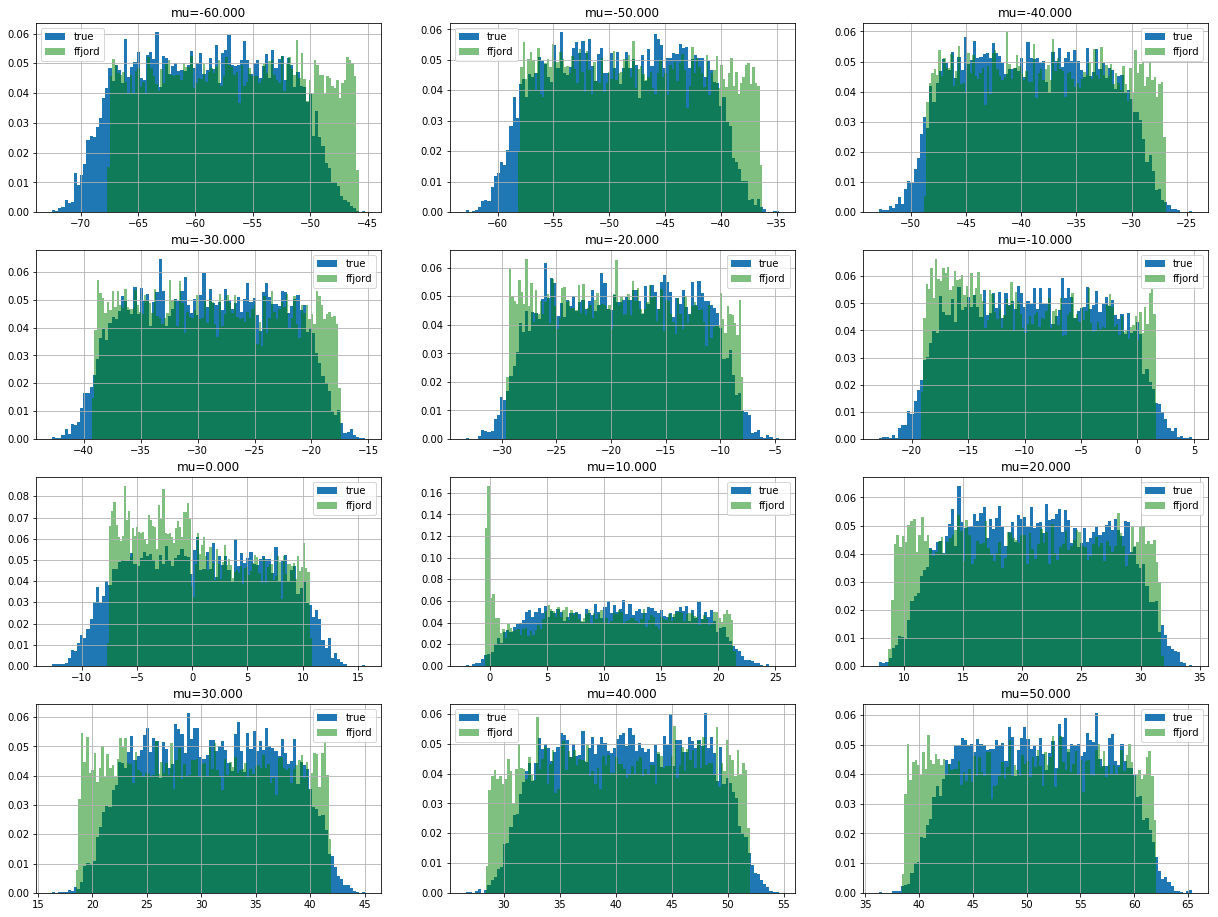

In [51]:
plt.figure(figsize=(21,16))
mu_range = list(range(-60, 60, 2))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        input_mu = torch.full(size=(10000, ), fill_value=mu_range[::len(mu_range) // 12][i * 3 + j])#.to(device)
        input_x = y_sampler.x_dist.sample(input_mu.shape).to(device)

        y_sampler.make_condition_sample({'mu': input_mu})
        data = y_sampler.condition_sample().detach().cpu().numpy()

        input_mu = input_mu.to(device)

        
        data_ref = torch.stack([0.1 * torch.randn(len(input_mu)).to(device), 
                                input_mu, input_x], dim=1).float()
        sampled = sample_fn(data_ref)
        
        
        plt.hist(data, bins=100, normed=True, label='true');
        plt.hist(sampled[:, 0].detach().cpu().numpy(),
             bins=100, color='g', density=True, alpha=0.5, label='ffjord');
        plt.grid()
        plt.legend()
        plt.title("mu={:.3f}".format(input_mu[0].item()))

# Density estimation

In [55]:
from scipy.signal import savgol_filter
def standard_normal_logprob_for_sampling(z, data):
    logZ = -0.5 * math.log(2 * math.pi)
    data_ref = torch.stack([torch.zeros(len(data)).to(data.device), 
                            data[:, 1],
                            data[:, 2]], dim=1).float()
    zpow = (z - data_ref).pow(2)
    sigmas = torch.tensor([1., 1., 1.]).float().to(data.device)
    return logZ - zpow / 2 / sigmas


def exp_normalize(x):
    b = x.max()
    y = np.exp(x - b)
    return y / y.sum()

def proba_fn(data_ref, density_fn):
    zero_ref = torch.stack([torch.zeros(len(data_ref)).to(device), 
                            data_ref[:, 1],
                            data_ref[:, 2]], dim=1).float()
    z, delta_logp = density_fn(data_ref, zero_ref)
    logpz = standard_normal_logprob_for_sampling(z, data_ref)
    logpx = logpz - delta_logp
    
    yhat = savgol_filter(logpx.sum(dim=1).detach().cpu().numpy(), 21, 3)
    proba = exp_normalize(yhat)
    return proba

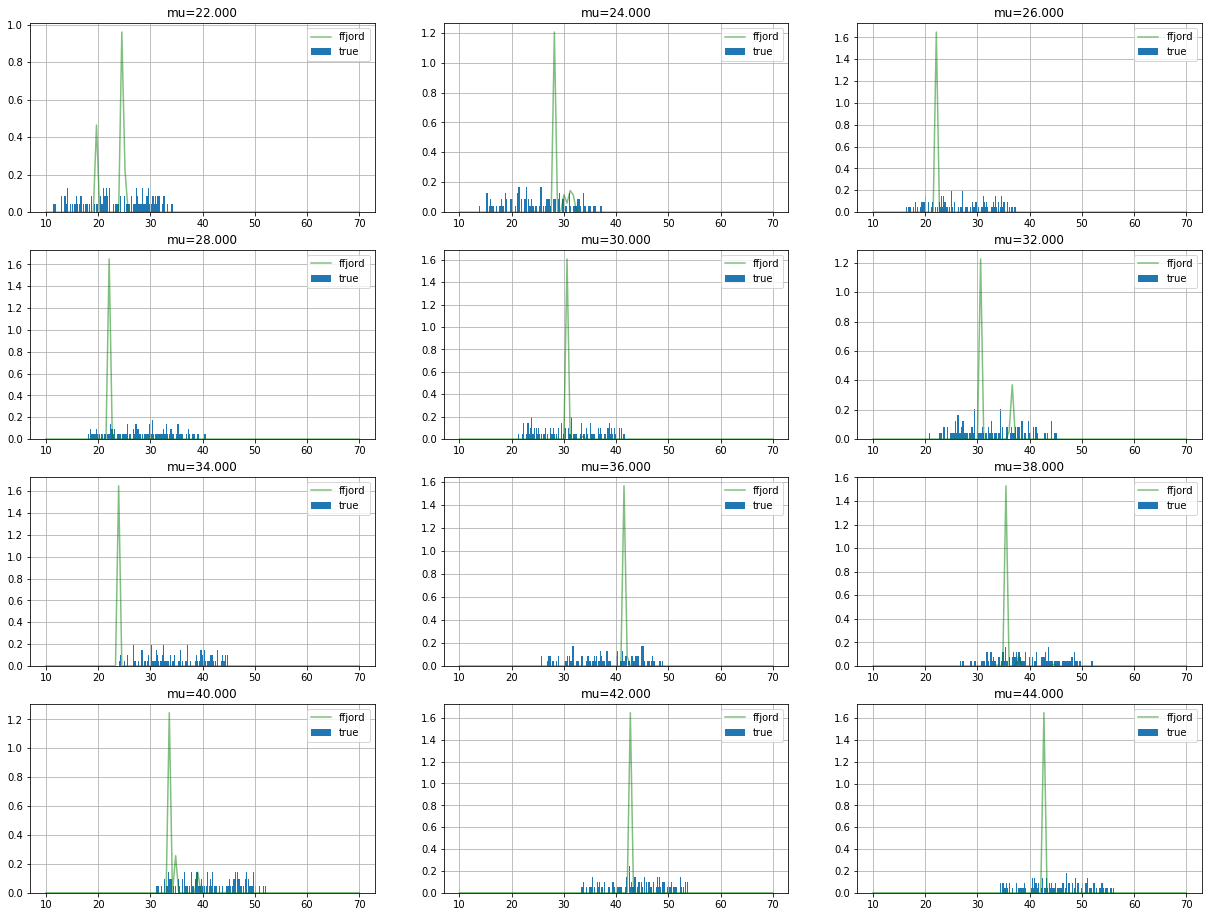

In [56]:
plt.figure(figsize=(21, 16))
mu_range = list(range(22, 60, 2))
for i in range(4):
    for j in range(3):
        plt.subplot(4, 3, i*3 + j + 1)
        input_mu = torch.full(size=(100, ), fill_value=mu_range[i*3 + j])#.to(device)
        input_x = y_sampler.x_dist.sample(input_mu.shape).to(device)

        y_sampler.make_condition_sample({'mu': input_mu})
        data = y_sampler.condition_sample().detach().cpu().numpy()

        input_mu = input_mu.to(device)

        ref = torch.linspace(10, 70, len(input_mu)).float().to(device)
        data_ref = torch.stack([ref, input_mu, input_x], dim=1).float()
        proba = proba_fn(data_ref, density_fn)
        plt.hist(data, bins=100, normed=True, label='true');
        plt.plot(ref.detach().cpu().numpy(), proba / (ref[1] - ref[0]).item(), color='g', alpha=0.5, label='ffjord');
        plt.grid()
        plt.legend()
        plt.title("mu={:.3f}".format(input_mu[0].item()))

# Test optimisation

In [58]:
lr = 0.1
sample_size = 5


mu_optim = torch.tensor(30.)
mu_optim = mu_optim.repeat(sample_size).to(device)
mu_optim.requires_grad=True

In [59]:
%%time
n_iter = 3000
losses = []
m_vals = []
for _iter in tqdm(range(n_iter)):    
    x = y_sampler.x_dist.sample([mu_optim.shape[0]]).to(device)
    # Do an update    
    data_ref = torch.stack([torch.randn(len(mu_optim)).to(device), 
                            mu_optim, x], dim=1).float()
    sampled = sample_fn(data_ref)
    
    loss = R(sampled[:, 0])
    losses.append(loss.item())
    if mu_optim.grad is not None: mu_optim.grad.zero_()
    loss.backward()
    with torch.no_grad():
        mu_optim -= lr * mu_optim.grad.mean()
        mu_optim.grad.zero_()
    m_vals.append(mu_optim[0].item())
    clear_output()
    
    print(_iter, mu_optim[0].item())




  6%|▋         | 189/3000 [30:22<8:22:24, 10.72s/it]

188 -5.146737098693848


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(losses);
plt.grid()
plt.ylabel("Loss", fontsize=19)
plt.xlabel("iter", fontsize=19)

Text(0.5, 0, 'iter')

Text(0.5, 0, 'iter')

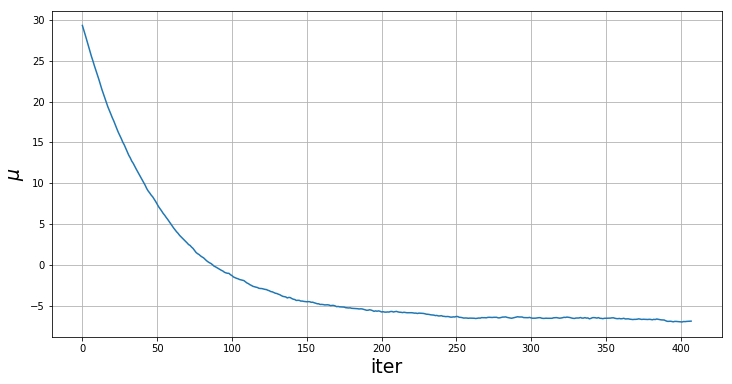

In [41]:
plt.figure(figsize=(12,6))
plt.plot(m_vals);
plt.grid()
plt.ylabel("$\mu$", fontsize=19)
plt.xlabel("iter", fontsize=19)